In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP, OjaRNN
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear
import configs

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/Users/chingfang/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


# Set up dataset

In [5]:
np.random.seed(0)

In [6]:
num_steps = 8000
num_states = 20

In [7]:
# Right-biased 1D Walk
dset = inputs.Sim1DWalk(
    num_steps=num_steps, left_right_stay_prob=[0.5, 1.5, 1],
    num_states=num_states
    )

In [50]:
# Set up dataset
dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
dg_modes = torch.from_numpy(dset.dg_modes.T).float().to(device).unsqueeze(1)
input_states = []
for t in range(dg_inputs.shape[0]):
    input_states.append(np.argwhere(dg_inputs[t,0])[0,0])
input_states = np.array(input_states)

# Get lap start indices
lap_starts = [0]
state_counts = np.zeros(num_states)
for t, input_state in enumerate(input_states):
    if not np.any(state_counts == 0):
        lap_starts.append(t)
        state_counts = np.zeros(num_states)
    state_counts[input_state] += 1
lap_starts = np.array(lap_starts)

# Plot induction laps

In [9]:
def run_and_plot(net, netname):
    Ms = []
    for step in range(dset.num_steps):
        curr_dg_input = dg_inputs[step].unsqueeze(0)
        curr_dg_mode = dg_modes[step].unsqueeze(0)
        reset = True if step == 0 else False
        _, outputs = net(curr_dg_input, curr_dg_mode, reset=reset)
        if step in lap_starts:
            Ms.append(net.get_M(0.9))
            
    chosen_state = 8
    num_laps = 10
    M_vectors = [M[chosen_state,:].detach().numpy() for M in Ms]
    M_vectors = np.array(M_vectors)
    
    plt.figure(figsize=(5,4))
    fields = M_vectors[:num_laps]
    fields = np.fliplr(fields)
    fields = np.roll(fields, shift=(num_states//2)+chosen_state, axis=1)
    plt.imshow(fields, cmap='viridis', aspect=1)
    plt.yticks(np.arange(0, num_laps, 5))
    plt.ylabel('Laps')
    tick_locs = np.array([0, 50, 100]) # In cm
    plt.xticks(tick_locs/configs.bin_to_cm, tick_locs)
    plt.xlabel('Position (cm)')
    plt.title(f'Example Linear Track Place Field')
    plt.savefig(f'field_induction_{netname}.png', dpi=200)
    plt.tight_layout()
    plt.show()

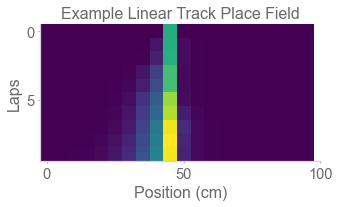

In [16]:
# RNN-Oja Network
net = OjaRNN(num_states, 0.4, ca3_kwargs={'start_valid':False, 'lr':5E-2})
netname = 'oja'
run_and_plot(net, netname)

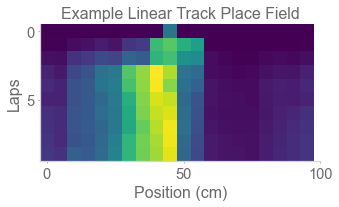

In [17]:
# RNN-SR Network
save_path = '../trained_models/baseline/'
model_path = save_path + 'model.pt'
net_configs_path = save_path + 'net_configs.p'
with open(net_configs_path, 'rb') as f:
    net_configs = pickle.load(f)
net_configs.pop('num_states')
#net_configs['ca3_kwargs']['gamma_T'] = 0.98
net = STDP_SR(num_states=num_states, **net_configs)
net.load_state_dict(torch.load(model_path))
netname = 'rnn'
run_and_plot(net, netname)

# Plot Learning Rates

In [18]:
Ms = []
etas = []
for step in range(dset.num_steps):
    curr_dg_input = dg_inputs[step].unsqueeze(0)
    curr_dg_mode = dg_modes[step].unsqueeze(0)
    reset = True if step == 0 else False
    _, outputs = net(curr_dg_input, curr_dg_mode, reset=reset)
    etas.append(1/net.ca3.eta_invs.detach().numpy().squeeze())

In [19]:
etas = np.array(np.clip(etas, 0, 1))

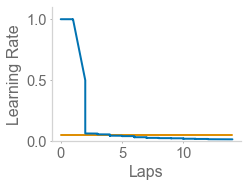

In [64]:
plt.figure(figsize=(6.4*0.6, 4.8*0.6))
_etas = etas[:800,1]
visits = (_etas[1:] - _etas[:-1]) < 0
_lap_starts = np.zeros(_etas.size)
_lap_starts[lap_starts[lap_starts <= _lap_starts.size]] = 1
num_laps = np.zeros(_etas.size)
for idx in range(1, num_laps.size):
    num_laps[idx] = np.sum(_lap_starts[:idx+1])
plt.plot(
    num_laps, [5E-2]*_etas.size, label='RNN-Oja',
    linewidth=2, color='C1'
    )
plt.plot(
    num_laps, _etas, label='RNN-SR',
    linewidth=2, color='C0'
    )
plt.ylim(0, 1.1)
plt.xlabel('Laps')
plt.ylabel('Learning Rate')
plt.tight_layout()
plt.savefig('2h_induction_etas.png', dpi=300)
plt.show()